In [1]:
import pymongo
import pandas as pd
import io
from PIL import Image
import os
from SETTINGS import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
def build_duplicate_lookup(rank_scores, threshold, group_on, collate_col, score_col='hash_score'):
    assigned = []
    agglom_dict = {}
    agglom = rank_scores[rank_scores[score_col] >= threshold].groupby(
    [group_on]).agg(
    {group_on: list,collate_col:list})
    for idx, row in agglom.iterrows():
        similars = row[collate_col]
        similars = list(set(similars) - set(assigned))
        if idx not in assigned:
            try:
                agglom_dict[idx].extend(similars)
            except KeyError:
                agglom_dict[idx] = similars
            assigned.extend(similars)

    final_dict = {}
    for k, v in agglom_dict.items():
        for item in v:
            final_dict[item] = k
    return final_dict

def show_image(path):
    img = Image.open(path)
    plt.show()
    return img

def image_sampler(tag_df, filename=None):
    if filename is None:
        filename = tag_df.sample(1)['filename'].values[0]
        
    sample_data = tag_df[tag_df['filename'] == filename].sort_values('score', ascending=False).set_index('filename')
        
    print(sample_data[['tag', 'score']])
    filepath = os.path.join(name_media_dir_path, filename)
    return show_image(filepath)

In [4]:
rank_scores = pd.read_pickle('rank_scores_with_sampling.pkl')
# rank_scores = pd.read_pickle('file_to_tag_scored.pkl')

In [5]:
duplicate_lookup = build_duplicate_lookup(rank_scores=rank_scores,
                          threshold=0.65,
                          group_on='a',
                          collate_col='b',
                          score_col='hash_score')

In [6]:
connection = pymongo.MongoClient()
db = connection[name_source_database]
collection = db[name_image_file_lookup]

In [7]:
projections = {k:1 for k in ['_id', 'count', 'filename','hash', 'labelAnnotations']}

In [8]:
image_tag_pipeline = [{'$match':{'_id':{'$exists':1}}}, {'$project':projections}]
image_tag_cursor = collection.aggregate(pipeline=image_tag_pipeline, allowDiskUse=True)

df = pd.DataFrame(image_tag_cursor)

In [9]:
df = df[~df.labelAnnotations.isna()]

# Deduping list

In [10]:
df.head()

,_id,count,filename,hash,labelAnnotations
0,http://pbs.twimg.com/media/BYPJ4QTCEAArCA7.jpg,1,00000.jpg,94985474d0f0b2f2,"[{'mid': '/m/01mqdt', 'description': 'Traffic ..."
1,http://pbs.twimg.com/media/C-ZZ2hsW0AAGJ4y.jpg,1,00001.jpg,f0ac7c3c3250b2b2,"[{'mid': '/m/05ws7', 'description': 'Police', ..."
2,http://pbs.twimg.com/media/C-Zb4ZqW0AARyIy.jpg,1,00002.jpg,156b665773ebfcde,"[{'mid': '/m/07bsy', 'description': 'Transport..."
4,http://pbs.twimg.com/media/C3HKX9JXgAAoyJe.jpg,1,01046.jpg,557525656565059b,"[{'mid': '/m/03scnj', 'description': 'Line', '..."
5,http://pbs.twimg.com/media/C3HKdBAXgAEVZ-g.jpg,1,01045.jpg,220e181a2a0e0f17,"[{'mid': '/m/07s6nbt', 'description': 'Text', ..."


In [11]:
len(df)

1256

In [12]:
files = df['filename']
unique_files = files.replace(duplicate_lookup).unique()
unique_files[:10]

array(['00000.jpg', '00001.jpg', '00002.jpg', '01046.jpg', '01045.jpg',
       '00004.jpg', '00005.jpg', '01044.jpg', '00006.jpg', '00007.jpg'],
      dtype=object)

In [13]:
df = df.set_index('filename').loc[unique_files].reset_index()

In [14]:
len(df)

956

# Building Tag data

In [15]:
data = []
for i, row in df.dropna(subset=['labelAnnotations']).iterrows():
    filename = row['filename']
    for tag_dict in row['labelAnnotations']:
        data_package = {}
        data_package['tag'] = tag_dict['description']
        data_package['score'] = tag_dict['score']
        data_package['filename'] = filename
        data.append(data_package)
tag_df = pd.DataFrame(data)

# tag_df = tag_df[tag_df.score > 0.85]

In [28]:
file_tag_scored = tag_df.pivot_table(index='filename', columns=['tag'], values='score', aggfunc='first').replace(pd.np.nan,0)

In [29]:
file_tag_scored.to_pickle('file_tag_scored.pkl')

# Building Tweet List

In [132]:
tweet_collection = db['tweet_image_lookup']
tweet_pipeline = [{'$match':{'_id':{'$exists':1}}}, {'$project':{'tweet_id':1, 'media_url':1}}]
tweet_cursor = tweet_collection.aggregate(pipeline=tweet_pipeline, allowDiskUse=True)
tweets = pd.DataFrame(tweet_cursor)

In [135]:
connector_pipeline = [{'$match':{'_id':{'$exists':1}}}, {'$project':{'_id':1, 'filename':1}}]
connector_cursor = collection.aggregate(pipeline=connector_pipeline, allowDiskUse=True)

connector = pd.DataFrame(connector_cursor, columns=['_id','filename'])

In [152]:
tweets_tagged = tweets.merge(connector, how='left', left_on='media_url',right_on='_id').drop(
    columns=['_id_x','_id_y']).replace(
    duplicate_lookup).merge(
    file_tag_scored, left_on='filename', right_index=True, how='left').dropna()

## Top Images List

In [154]:
top_images = tweets_tagged['filename'].value_counts()
top_images.head()

00820.jpg    68
00806.jpg    66
00070.jpg    55
00721.jpg    35
00937.jpg    30
Name: filename, dtype: int64

In [155]:
top_subset = pd.DataFrame(file_tag_scored.loc[top_images.index].stack(), columns=['score']).reset_index().rename(columns={'level_0':'filename'})
top_subset = top_subset.merge(top_images, left_on='filename', right_index=True, how='left').rename(columns={'filename_x':'filename', 'filename_y':'tweet_count'})

top_subset = top_subset.set_index(['tweet_count','filename']).sort_values('score', ascending=False).sort_index(ascending=False)
# top_subset.index = top_subset.index.droplevel()
top_subset = pd.DataFrame(top_subset.groupby(top_subset.index)['tag'].apply(list).sort_index(ascending=False)).reset_index().rename(columns={'index':'old_index'})
top_subset['n_uses'], top_subset['filename'] = top_subset.old_index.apply(lambda x: x[0]), top_subset.old_index.apply(lambda x: x[1])
top_subset.drop(columns=['old_index'], inplace=True)
top_subset['tag'] = top_subset['tag'].apply(lambda x: x[:3])
top_subset.head()

,tag,n_uses,filename
0,"[Cartoon, Text, Font]",68,00820.jpg
1,"[Text, Map, Ecoregion]",66,00806.jpg
2,"[Protest, Youth, Event]",55,00070.jpg
3,"[Businessperson, Event, Gentleman]",35,00721.jpg
4,"[Protest, People, Event]",30,00937.jpg


In [221]:
tweets = tweets_tagged[['tweet_id','filename','media_url']].copy()
tweets['tweet_id'] = tweets['tweet_id'].astype(int)

In [222]:
tweets = tweets.merge(top_subset, on='filename', how='left').drop(columns=['n_uses'])

In [223]:
required_ids = tweets['tweet_id'].tolist()
required_ids = [int(x) for x in required_ids]

tweet_pipeline = [{'$match':{'id':{'$in':required_ids}, 'retweeted_status':{'$exists':0}}},
                 {'$project':{'id':1, 'text':1,'full_text':1, 'extended_tweet.full_text':1}}]
# tweet_pipeline = [{'$match':{'id':{'$in':required_ids}}},
#                  {'$project':{'id':1, 'text':1,'full_text':1, 'extended_tweet.full_text':1}}]
tweet_cursor = db['tweets'].aggregate(pipeline=tweet_pipeline, allowDiskUse=True)
tweet_text_df = pd.DataFrame(tweet_cursor)

In [224]:
def choose_text(record):
    options = [record['full_text'], record['unpack'], record['text']]
    lens = [len(x) if x is not pd.np.nan else 0 for x in options]
    longest = lens.index(max(lens))
    return options[longest]

In [225]:
tweet_text_df['unpack'] = tweet_text_df['extended_tweet'].apply(lambda x: x['full_text'] if x is not pd.np.nan else pd.np.nan)

In [226]:
tweet_text_df['new_text'] = tweet_text_df.apply(choose_text, axis=1)

In [227]:
tweet_text_df.drop(columns=['extended_tweet', 'unpack','full_text','text','_id'],inplace=True)
tweet_text_df.rename(columns={'new_text':'text', 'id':'tweet_id'}, inplace=True)

In [228]:
tweets = tweets.merge(tweet_text_df,on='tweet_id')

# Dimensionality Reduced Version

## Independent Component Analysis

In [16]:
file_tag_scored = pd.read_pickle('file_to_tag_scored.pkl')

In [17]:
from visualising import plotly_3d

In [18]:
from sklearn.decomposition import FastICA 
ICA = FastICA(n_components=3, random_state=12) 
ICA_X=ICA.fit_transform(file_tag_scored.values)


In [21]:
ICA_X = pd.DataFrame(ICA_X, columns=['x','y','z'])
ICA_X['filename'] = file_tag_scored.index

# ICA_X.plot.scatter('x','y')

# plotly_3d(df=ICA_X, filename='ICA_X_scored.html')

## Principal Component Analysis

In [22]:
from sklearn.decomposition import PCA 
PCA = PCA(n_components=3, random_state=12) 
PCA_X = PCA.fit_transform(file_tag_scored.values)

In [23]:
PCA_X = pd.DataFrame(PCA_X, columns=['x','y','z'])
PCA_X['filename'] = file_tag_scored.index


# PCA_X.plot.scatter('x','y')
# plotly_3d(df=PCA_X, filename='PCA_X_scored.html')

# K-Means Clustering

In [24]:
from analysis_funcs import Kmeans_Optimal_Clusterer

In [25]:
data = PCA_X[['x','y','z']]

In [26]:
kmoc = Kmeans_Optimal_Clusterer(data, min_max_clusters=(2,20))

In [27]:
kmoc_scores = pd.DataFrame([[k, v['score'], v['inertia']] for k,v in kmoc.data_dict.items()], columns=['k','sillouhette','inertia']).set_index('k').sort_values('sillouhette', ascending=False)

In [185]:
from sklearn.preprocessing import MinMaxScaler

In [186]:
scaler = MinMaxScaler()

In [187]:
kmoc_scores = pd.DataFrame(scaler.fit_transform(kmoc_scores), columns=kmoc_scores.columns, index=kmoc_scores.index)

In [188]:
kmoc_scores['inverted_inertia'] = 1 - kmoc_scores['inertia']

In [189]:
kmoc_scores['avg_score'] = kmoc_scores.apply(lambda x: (x['sillouhette'] +x['inverted_inertia']) /2, axis=1)

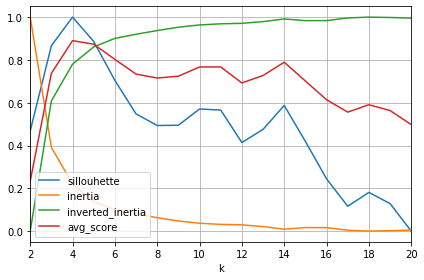

In [190]:
kmoc_scores.sort_index().plot()
plt.tight_layout()
plt.grid(True)

In [191]:
k_choice = 4

In [192]:
data['k_labels'] = kmoc.data_dict[k_choice]['labels']

In [193]:
# seaborn.scatterplot(data=data, x='x', y='y', hue='k_labels', palette='Paired', legend='full')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plotly_3d(df=data,groupby='k_labels', filename=f'{k_choice}_PCA_X_kmeans_labelled.html')

# HDBSCAN Clustering

# Selecting a Grouping

In [194]:
labels = kmoc.data_dict[k_choice]['labels']

grouped_files = pd.DataFrame(labels, index=file_tag_scored.index, columns=['group'])

In [195]:
g = grouped_files.groupby('group')
print(len(g.groups))

4


In [196]:
from shutil import copy2
from functions import if_no_dir_make

In [197]:
for name, group in g:
    group_dir = if_no_dir_make(os.path.join(name_media_dir_path, str(name)))
    for file in group.index:
        file_source = os.path.join(name_media_dir_path,file)
        copy2(file_source,group_dir)

In [198]:
file_tag_scored.head()

tag,Abdomen,Academic conference,Acrobatics,Action figure,Action film,Active shirt,Adaptation,Adventure,Advertising,Aerial photography,...,Woody plant,World,Wrinkle,Wrist,Yard,Yellow,Youth,chamomile,heater,mayweed
filename,,,,,,,,,,,,,,,,,,,,,
00000.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00001.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00002.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00004.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00005.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [199]:
n_top_tags = 10

grouped_tags = grouped_files.merge(file_tag_scored, how='left',
                    left_index=True,
                    right_index=True)

In [200]:
top_tags_group = pd.DataFrame(grouped_tags.groupby('group').apply(lambda group: group.drop(columns=['group']).mean().sort_values(ascending=False).head(n_top_tags)),columns=['Mean_Confidence_score'])
top_tags_group.to_html(f'{k_choice}_group_top_tags.html')

In [201]:
sns.set_context('paper')

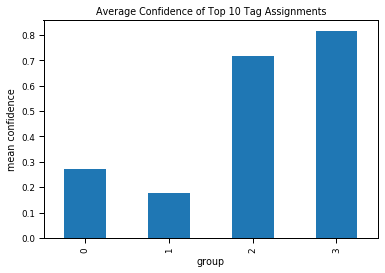

In [202]:
grouped_tags.groupby('group', as_index=True).apply(lambda g: g.mean().sort_values(ascending=False).head(n_top_tags).mean()).plot(kind='bar')
plt.ylabel('mean confidence')
plt.title(f'Average Confidence of Top {n_top_tags} Tag Assignments')

plt.show()

In [205]:
top_subset.merge(grouped_files, left_on='filename', right_index=True).to_excel('top_images.xlsx')

In [229]:
tweets = tweets.merge(grouped_files, left_on='filename', right_index=True, how='left')

In [230]:
tweets['tweet_id'] = tweets['tweet_id'].astype(str)

In [231]:
mask_filelist = top_subset[top_subset['n_uses'] >= 10]['filename'].tolist()

In [232]:
top_filename_tweets = tweets[tweets['filename'].isin(mask_filelist)].reset_index()
top_filename_tweets.to_excel('new_top_image_tweets.xlsx')

In [427]:
tweets.tweet_id.value_counts()

1009567620964679680    4
1071890867424763906    4
1104371761251012608    4
1071897727431335937    4
1071891456875466758    4
                      ..
1017327829422432256    1
1056673892759228416    1
1056529559384977408    1
1052141669141876736    1
1064562535976837121    1
Name: tweet_id, Length: 990, dtype: int64

# Hierarchical Clustering

In [112]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist, squareform
from analysis_funcs import fancy_dendrogram

In [114]:
methods = ['single','complete','average','weighted']
distances = pdist(file_tag_onehot)
scores = []
for method in methods:
    Z = linkage(file_tag_onehot,method)
    c, coph_dists = cophenet(Z, distances)
    scores.append(c)
    print(f'{method}: {c}')
top_method = pd.Series(scores, index=methods).idxmax()


single: 0.7694344637615766
complete: 0.538062207436878
average: 0.8741532987979651
weighted: 0.7153272458665626


In [117]:
Z = linkage(file_tag_onehot, 'complete')

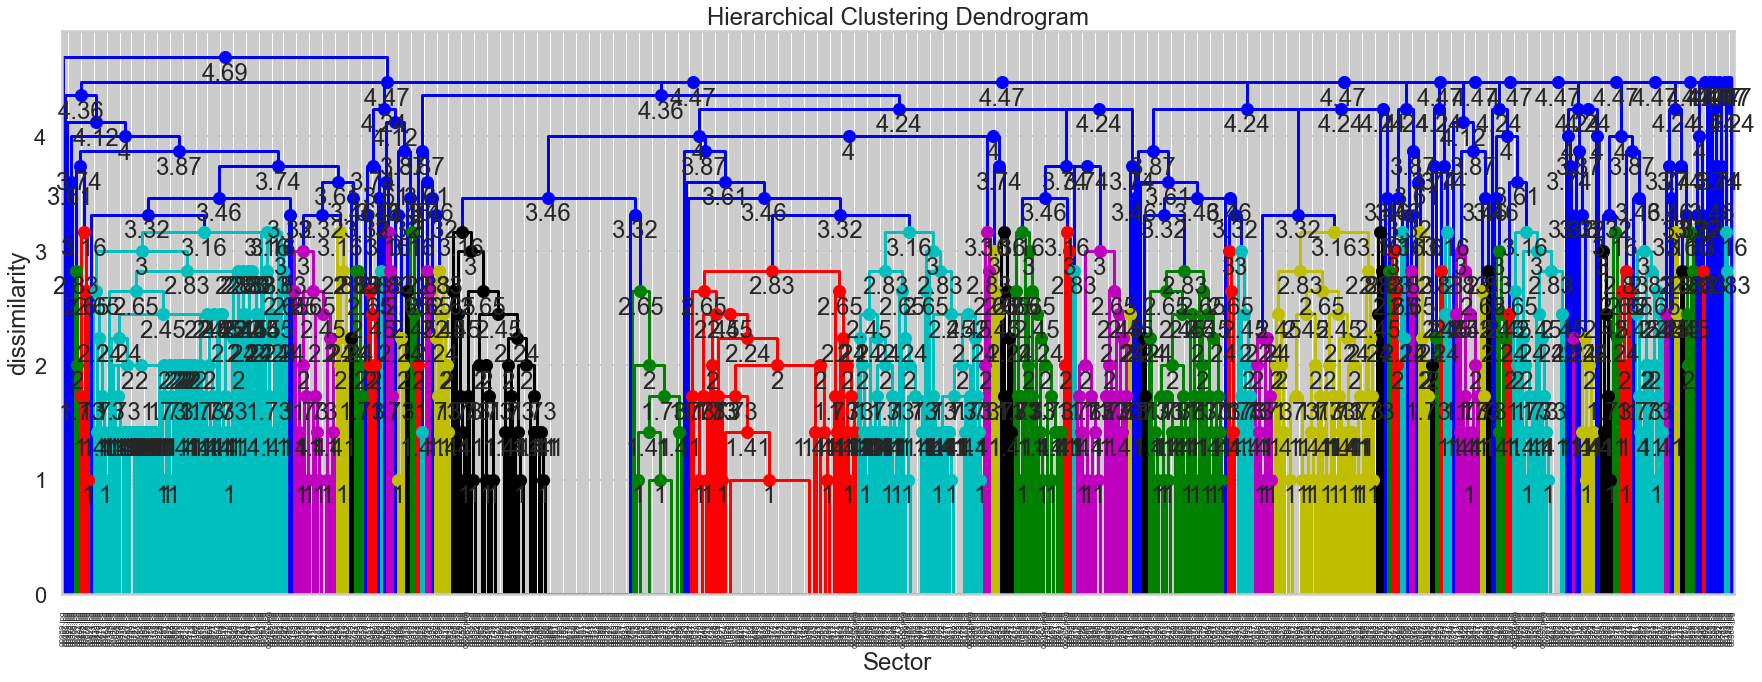

In [118]:
plt.figure(figsize=(25, 10))

fancy_dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels=file_tag_onehot.index.tolist()

)
plt.tight_layout()
plt.show()

In [47]:
from scipy.cluster.hierarchy import fcluster
max_d = 50
clusters = fcluster(Z, 4, criterion='maxclust')
file_tag_onehot['h_community'] = clusters

In [48]:
file_tag_onehot.groupby(['h_community',file_tag_onehot.index]).sum()

Academic conference  Acrobatics  Action figure  \
h_community filename                                                    
1           00028.jpg                    0           0              0   
            00029.jpg                    0           0              0   
            00034.jpg                    0           0              0   
            00042.jpg                    0           0              0   
            00043.jpg                    0           0              0   
...                                    ...         ...            ...   
2           01037.jpg                    0           0              0   
            01038.jpg                    0           0              0   
            01039.jpg                    0           0              0   
            01040.jpg                    0           0              0   
3           00989.jpg                    0           0              0   

                       Action film  Active shirt  Adaptation  Adventure  \
h_community filename                                                      
1           00028.jpg            0             0           0          0   
            00029.jpg            0             0           0          0   
            00034.jpg            0             0           0          0   
            00042.jpg            0             0           0          0   
            00043.jpg            0             0           0          0   
...                            ...           ...         ...        ...   
2           01037.jpg            0             0           0          0   
            01038.jpg            0             0           0          0   
            01039.jpg            0             0           0          0   
            01040.jpg            0             0           0          0   
3           00989.jpg            0             0           0          0   

                       Advertising  Aerial photography  Aerialist  ...  Wood  \
h_community filename                                               ...         
1           00028.jpg            0                   0          0  ...     0   
            00029.jpg            0                   0          0  ...     0   
            00034.jpg            0                   0          0  ...     0   
            00042.jpg            0                   0          0  ...     0   
            00043.jpg            0                   0          0  ...     0   
...                            ...                 ...        ...  ...   ...   
2           01037.jpg            0                   0          0  ...     0   
            01038.jpg            0                   0          0  ...     0   
            01039.jpg            0                   0          0  ...     0   
            01040.jpg            0                   0          0  ...     0   
3           00989.jpg            0                   0          0  ...     0   

                       Woodland  Woody plant  World  Yard  Yellow  Youth  \
h_community filename                                                       
1           00028.jpg         0            0      0     0       0      0   
            00029.jpg         0            0      0     0       0      0   
            00034.jpg         0            0      0     0       0      0   
            00042.jpg         0            0      0     0       0      0   
            00043.jpg         0            0      0     0       0      0   
...                         ...          ...    ...   ...     ...    ...   
2           01037.jpg         0            0      0     0       0      0   
            01038.jpg         0            0      0     0       1      0   
            01039.jpg         0            0      0     0       0      0   
            01040.jpg         0            0      0     0       0      0   
3           00989.jpg         0            0      0     0       0      0   

                       chamomile  heater  mayweed  
h_community fil

# Random Forests